In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import contractions
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
df = pd.read_csv(r"D:\datasets\IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
stop = stopwords.words("english")
l= list(punctuation)
extra = ["'s", "``", "''", "`"]
stop_word = l + stop + extra

In [5]:
wl = WordNetLemmatizer()

In [6]:
def clean_text(text):
    text = contractions.fix(text)  # expand contractions
    text = text.lower()  # lowercase
    text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML tags
    text = re.sub(r'\d+', '', text)  # remove numbers
    tokens = word_tokenize(text) 
    tokens = [word for word in tokens if word not in stop_word and word.isalpha()]
    tokens = [wl.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [7]:
df["review"] = df["review"].apply(clean_text)

C:\Users\aksra\AppData\Local\Temp\ipykernel_4280\668245406.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML tags


In [9]:
df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


In [10]:
x = df[["review"]]
y = df['sentiment']

In [11]:
tfidf = TfidfVectorizer(max_features=30000, dtype=np.float32,ngram_range=(1,2))
x = tfidf.fit_transform(df["review"])

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)

In [13]:
lr=LogisticRegression(max_iter=1000,class_weight="balanced")
lr.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [14]:
lr.score(x_train,y_train)*100,lr.score(x_test,y_test)*100

(93.37066666666666, 89.736)

In [15]:
mnb = MultinomialNB()
mnb.fit(x_train,y_train)

MultinomialNB()

In [16]:
mnb.score(x_train,y_train)*100, mnb.score(x_test,y_test)*100

(90.352, 87.872)

In [17]:
sv=LinearSVC()
sv.fit(x_train,y_train)

C:\Users\aksra\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [18]:
sv.score(x_train,y_train)*100, sv.score(x_test,y_test)*100

(98.85066666666667, 89.688)

In [19]:
vc = VotingClassifier(estimators=[
    ("lr", LogisticRegression(max_iter=1000)),
    ("mnb", MultinomialNB()),
    ("sv",LinearSVC())])

In [20]:
vc.fit(x_train,y_train)

C:\Users\aksra\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('mnb', MultinomialNB()), ('sv', LinearSVC())])

In [21]:
vc.score(x_train,y_train)*100,vc.score(x_test,y_test)*100

(94.97066666666667, 89.968)

In [22]:
models = {"Multinomial Naive Bayes": mnb,"Logistic Regression": lr,"SVC": sv,"Voting Classifier": vc}

In [23]:
def evaluate_model(model, x_train, y_train, x_test, y_test, name):
    y_pred = model.predict(x_test)
    x = {"Model": name,
        "Train Accuracy": accuracy_score(y_train, model.predict(x_train)) * 100,
        "Test Accuracy": accuracy_score(y_test, y_pred) * 100,
        "Precision": precision_score(y_test, y_pred, average="weighted") * 100,
        "Recall": recall_score(y_test, y_pred, average="weighted") * 100,
        "F1-Score": f1_score(y_test, y_pred, average="weighted") * 100}
    return x

In [24]:
results = []
for name, model in models.items(): 
    results.append(evaluate_model(model, x_train, y_train, x_test, y_test, name))

In [25]:
df_results = pd.DataFrame(results).round(2)
print(df_results)

                     Model  Train Accuracy  Test Accuracy  Precision  Recall  \
0  Multinomial Naive Bayes           90.35          87.87      87.88   87.87   
1      Logistic Regression           93.37          89.74      89.76   89.74   
2                      SVC           98.85          89.69      89.69   89.69   
3        Voting Classifier           94.97          89.97      89.98   89.97   

   F1-Score  
0     87.87  
1     89.73  
2     89.69  
3     89.97  


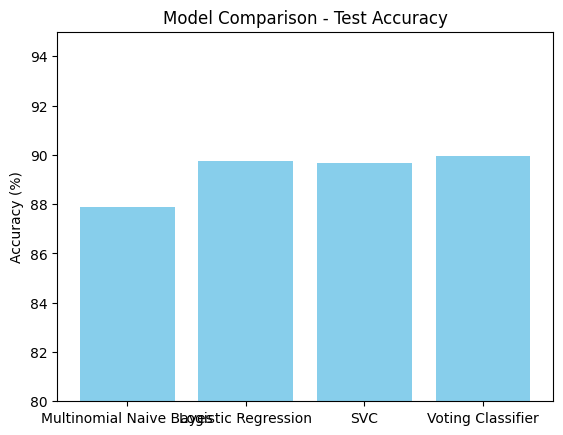

In [26]:
plt.bar(df_results["Model"], df_results["Test Accuracy"], color="skyblue")
plt.title("Model Comparison - Test Accuracy")
plt.ylim(80,95)
plt.ylabel("Accuracy (%)")
plt.show()

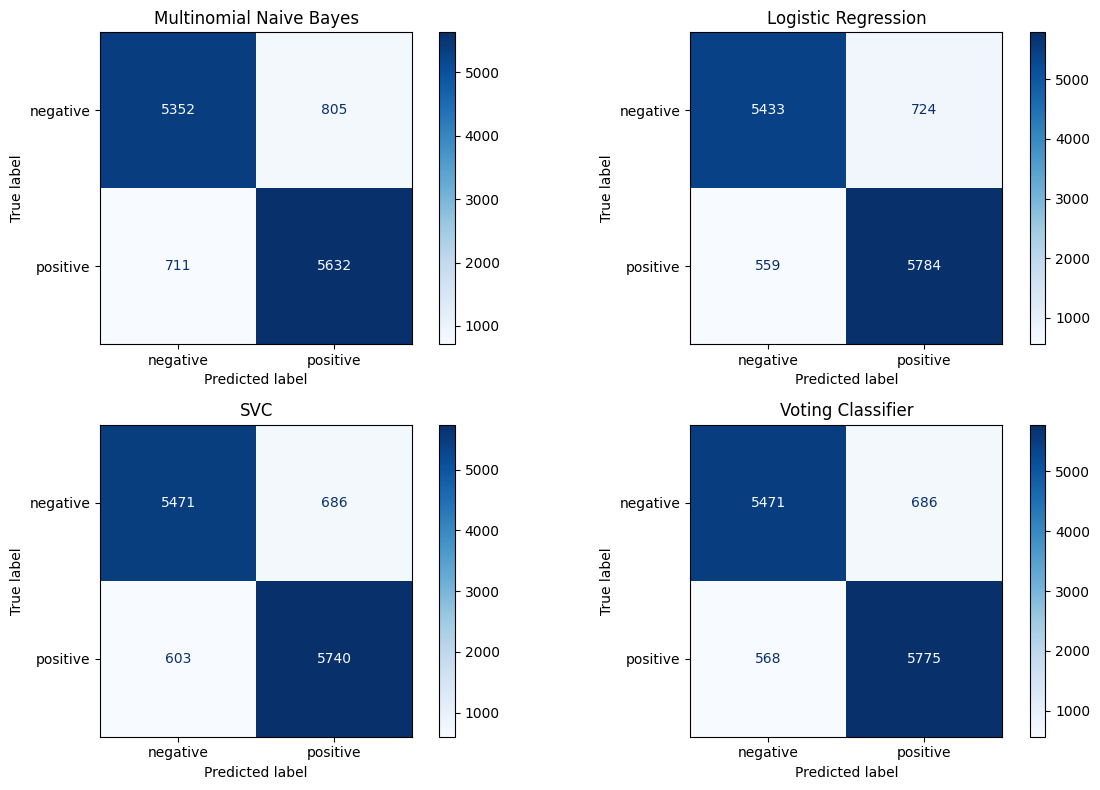

In [27]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes_list = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
i = 0
for name, model in models.items():
    y_pred = model.predict(x_test)  
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes_list[i], cmap="Blues")
    axes_list[i].set_title(name)
    i += 1
plt.tight_layout()
plt.show()